In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import boto3
import pandas as pd
from io import BytesIO
from io import StringIO
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tqdm import tqdm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Initialize S3 client
s3 = boto3.client('s3')

# Function to load data 
bucket_name = 'ml-stack-759578648427-us-west-2'

def from_s3(bucket_name, file_name):
    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    ext = os.path.splitext(file_name)[1]
    if ext == '.gz':
        data = pd.read_csv(BytesIO(response['Body'].read()), compression='gzip')
    elif ext == '.csv':
        data = pd.read_csv(BytesIO(response['Body'].read()))
    else:
        data = pd.read_excel(BytesIO(response['Body'].read()), sheet_name='DX_to_CCSR_Mapping', header=1)
    return data

# Import Labeled Data

In [3]:
file_name = 'final_microbiology_df.csv.gz'
df = from_s3(bucket_name, file_name) 
df['charttime'] = pd.to_datetime(df['charttime'])
subjects = df['subject_id'].unique()
df.head()

,subject_id,hadm_id,org_name,ab_name,charttime,interpretation,susceptible_flag
0,10000826,20032235.000,ESCHERICHIA COLI,AMPICILLIN,2146-12-08 22:22:00,S,1.000
1,10000826,20032235.000,ESCHERICHIA COLI,AMPICILLIN/SULBACTAM,2146-12-08 22:22:00,S,1.000
2,10000826,20032235.000,ESCHERICHIA COLI,CEFAZOLIN,2146-12-08 22:22:00,S,1.000
3,10000826,20032235.000,ESCHERICHIA COLI,CEFEPIME,2146-12-08 22:22:00,S,1.000
4,10000826,20032235.000,ESCHERICHIA COLI,CEFTAZIDIME,2146-12-08 22:22:00,S,1.000


In [4]:
# final pairs 
pairs = [('ESCHERICHIA COLI', 'AMPICILLIN'),
 ('ESCHERICHIA COLI', 'AMPICILLIN/SULBACTAM'),
 ('ESCHERICHIA COLI', 'CEFAZOLIN'),
 ('ESCHERICHIA COLI', 'CEFEPIME'),
 ('ESCHERICHIA COLI', 'CEFTAZIDIME'),
 ('ESCHERICHIA COLI', 'CEFTRIAXONE'),
 ('ESCHERICHIA COLI', 'CIPROFLOXACIN'),
 ('ESCHERICHIA COLI', 'GENTAMICIN'),
 ('ESCHERICHIA COLI', 'MEROPENEM'),
 ('ESCHERICHIA COLI', 'NITROFURANTOIN'),
 ('ESCHERICHIA COLI', 'TOBRAMYCIN'),
 ('ESCHERICHIA COLI', 'TRIMETHOPRIM/SULFA'),
 ('PSEUDOMONAS AERUGINOSA', 'CEFEPIME'),
 ('PSEUDOMONAS AERUGINOSA', 'CEFTAZIDIME'),
 ('PSEUDOMONAS AERUGINOSA', 'CIPROFLOXACIN'),
 ('PSEUDOMONAS AERUGINOSA', 'GENTAMICIN'),
 ('PSEUDOMONAS AERUGINOSA', 'MEROPENEM'),
 ('PSEUDOMONAS AERUGINOSA', 'PIPERACILLIN/TAZO'),
 ('PSEUDOMONAS AERUGINOSA', 'TOBRAMYCIN'),
 ('ESCHERICHIA COLI', 'PIPERACILLIN/TAZO'),
 ('KLEBSIELLA PNEUMONIAE', 'AMPICILLIN/SULBACTAM'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFAZOLIN'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFEPIME'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFTAZIDIME'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFTRIAXONE'),
 ('KLEBSIELLA PNEUMONIAE', 'CIPROFLOXACIN'),
 ('KLEBSIELLA PNEUMONIAE', 'GENTAMICIN'),
 ('KLEBSIELLA PNEUMONIAE', 'MEROPENEM'),
 ('KLEBSIELLA PNEUMONIAE', 'NITROFURANTOIN'),
 ('KLEBSIELLA PNEUMONIAE', 'PIPERACILLIN/TAZO'),
 ('KLEBSIELLA PNEUMONIAE', 'TOBRAMYCIN'),
 ('KLEBSIELLA PNEUMONIAE', 'TRIMETHOPRIM/SULFA')]

df = df[df[['org_name', 'ab_name']].apply(tuple, axis=1).isin(pairs)]

# Features

In [5]:
pd.options.display.max_seq_items = 4000

In [6]:
file_name = 'MIMIC/Cleaned/df_omr_pt_ad_diag_proc_pr.csv'
feat = from_s3(bucket_name, file_name)
feat.rename({'99':'DIAG_99'}, axis=1, inplace=True)
feat['charttime'] = pd.to_datetime(feat['charttime'])
feat.head()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,gender,anchor_age,insurance,language,marital_status,race,DIAG_99,BLD001,BLD002,BLD003,BLD004,BLD005,BLD006,BLD007,BLD008,BLD009,BLD010,CIR001,CIR002,CIR003,CIR004,CIR005,CIR006,CIR007,CIR008,CIR009,CIR010,CIR011,CIR012,CIR013,CIR014,CIR015,CIR016,CIR017,CIR018,CIR019,CIR020,CIR021,CIR022,CIR023,CIR024,CIR025,CIR026,CIR027,CIR028,CIR029,CIR030,CIR031,CIR032,CIR033,CIR034,CIR035,CIR036,CIR037,CIR038,CIR039,DEN001,DEN002,DEN003,DIG001,DIG002,DIG003,DIG004,DIG005,DIG006,DIG007,DIG008,DIG009,DIG010,DIG011,DIG012,DIG013,DIG014,DIG015,DIG016,DIG017,DIG018,DIG019,DIG020,DIG021,DIG022,DIG023,DIG024,DIG025,EAR001,EAR002,EAR003,EAR004,EAR005,EAR006,END001,END002,END003,END004,END005,END006,END007,END008,END009,END010,END011,END012,END013,END014,END015,END016,END017,EXT001,EXT002,EXT003,EXT004,EXT005,EXT006,EXT007,EXT008,EXT009,EXT010,EXT011,EXT012,EXT013,EXT014,EXT015,EXT016,EXT017,EXT018,EXT019,EXT020,EXT021,EXT022,EXT023,EXT024,EXT025,EXT026,EXT027,EXT028,EXT029,EXT030,EYE001,EYE002,EYE003,EYE004,EYE005,EYE006,EYE007,EYE008,EYE009,EYE010,EYE011,EYE012,FAC001,FAC002,FAC003,FAC004,FAC005,FAC006,FAC008,FAC009,FAC010,FAC012,FAC013,FAC014,FAC015,FAC016,FAC017,FAC019,FAC020,FAC022,FAC023,FAC024,FAC025,FAC026,FAC027,FAC028,FAC029,FAC030,GEN001,GEN002,GEN003,GEN004,GEN005,GEN006,GEN007,GEN008,GEN009,GEN010,GEN011,GEN012,GEN013,GEN014,GEN015,GEN016,GEN017,GEN018,GEN019,GEN020,GEN021,GEN022,GEN023,GEN024,GEN025,GEN026,INF001,INF002,INF003,INF004,INF005,INF006,INF007,INF008,INF009,INF010,INF011,INF012,INJ001,INJ002,INJ003,INJ004,INJ005,INJ006,INJ007,INJ008,INJ009,INJ010,INJ011,INJ012,INJ013,INJ014,INJ015,INJ016,INJ017,INJ018,INJ019,INJ020,INJ021,INJ022,INJ023,INJ024,INJ025,INJ026,INJ027,INJ028,INJ029,INJ030,INJ031,INJ032,INJ033,INJ034,INJ035,INJ036,INJ037,INJ038,INJ039,INJ040,INJ041,INJ042,INJ043,INJ044,INJ045,INJ046,INJ047,INJ048,INJ049,INJ050,INJ054,INJ055,INJ056,INJ057,INJ059,INJ060,INJ061,INJ062,INJ063,INJ064,INJ065,INJ066,INJ067,INJ069,INJ070,INJ071,INJ072,INJ073,INJ074,INJ075,INJ076,MAL001,MAL002,MAL003,MAL004,MAL005,MAL006,MAL007,MAL008,MAL009,MAL010,MBD001,MBD002,MBD003,MBD004,MBD005,MBD006,MBD007,MBD008,MBD009,MBD010,MBD011,MBD012,MBD013,MBD014,MBD017,MBD018,MBD019,MBD020,MBD021,MBD022,MBD023,MBD024,MBD025,MBD026,MBD027,MBD028,MBD032,MBD034,MUS001,MUS002,MUS003,MUS004,MUS005,MUS006,MUS007,MUS008,MUS009,MUS010,MUS011,MUS012,MUS013,MUS014,MUS015,MUS016,MUS017,MUS020,MUS021,MUS022,MUS023,MUS024,MUS025,MUS026,MUS027,MUS028,MUS029,MUS030,MUS031,MUS032,MUS033,MUS034,MUS035,MUS036,MUS037,MUS038,NEO001,NEO002,NEO003,NEO004,NEO005,NEO006,NEO007,NEO008,NEO009,NEO010,NEO011,NEO012,NEO013,NEO014,NEO015,NEO016,NEO017,NEO018,NEO019,NEO020,NEO021,NEO022,NEO023,NEO024,NEO025,NEO026,NEO027,NEO028,NEO029,NEO030,NEO031,NEO032,NEO033,NEO034,NEO035,NEO036,NEO037,NEO038,NEO039,NEO040,NEO041,NEO042,NEO043,NEO044,NEO045,NEO046,NEO047,NEO048,NEO049,NEO050,NEO051,NEO052,NEO054,NEO056,NEO057,NEO058,NEO059,NEO060,NEO061,NEO062,NEO063,NEO064,NEO065,NEO066,NEO067,NEO068,NEO069,NEO070,NEO071,NEO072,NEO073,NEO074,NEO075,NEO078,NVS001,NVS002,NVS003,NVS004,NVS005,NVS006,NVS007,NVS008,NVS009,NVS010,NVS011,NVS012,NVS013,NVS014,NVS015,NVS016,NVS017,NVS018,NVS019,NVS020,NVS021,NVS022,PNL004,PNL006,PNL009,PNL010,PNL013,PNL015,PRG002,PRG003,PRG004,PRG005,PRG006,PRG007,PRG008,PRG009,PRG010,PRG011,PRG012,PRG013,PRG014,PRG015,PRG016,PRG017,PRG018,PRG019,PRG020,PRG021,PRG022,PRG023,PRG024,PRG025,PRG026,PRG027,PRG028,PRG029,PRG030,RSP001,RSP002,RSP003,RSP004,RSP005,RSP006,RSP007,RSP008,RSP009,RSP010,RSP011,RSP012,RSP013,RSP014,RSP015,RSP016,RSP017,SKN001,SKN002,SKN003,SKN004,SKN005,SKN006,SKN007,SYM001,SYM002,SYM003,SYM004,SYM005,SYM006,SYM007,SYM008,SYM009,SYM010,SYM011,SYM012,SYM013,SYM014,SYM015,SYM016,SYM017,SYM018,procedure_ct,days_since_last_proc,A01AA,A01AB,A01AC,A01AD,A02AA,A02AB,A02AC,A02AF,A02AH,A02BA,A02BB,A02BC,A02BD,A02BX,A03AA,A03AX,A03BA,A03CB,A03FA,A04AA,A04AD,A05AA,A06AA,A06AB,A06AC,A06AD,A

In [7]:
# change data types 
feat.gender = feat.gender.astype('object')
feat.insurance = feat.insurance.astype('object')
feat.language = feat.language.astype('object')
feat.marital_status = feat.marital_status.astype('object')
feat.race = feat.race.astype('object')

# one hote encode categorical features 
categorical_columns = feat.select_dtypes(include=['object']).columns
feat_encoded = pd.get_dummies(feat, columns=categorical_columns)
feat_encoded.head()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,anchor_age,DIAG_99,BLD001,BLD002,BLD003,BLD004,BLD005,BLD006,BLD007,BLD008,BLD009,BLD010,CIR001,CIR002,CIR003,CIR004,CIR005,CIR006,CIR007,CIR008,CIR009,CIR010,CIR011,CIR012,CIR013,CIR014,CIR015,CIR016,CIR017,CIR018,CIR019,CIR020,CIR021,CIR022,CIR023,CIR024,CIR025,CIR026,CIR027,CIR028,CIR029,CIR030,CIR031,CIR032,CIR033,CIR034,CIR035,CIR036,CIR037,CIR038,CIR039,DEN001,DEN002,DEN003,DIG001,DIG002,DIG003,DIG004,DIG005,DIG006,DIG007,DIG008,DIG009,DIG010,DIG011,DIG012,DIG013,DIG014,DIG015,DIG016,DIG017,DIG018,DIG019,DIG020,DIG021,DIG022,DIG023,DIG024,DIG025,EAR001,EAR002,EAR003,EAR004,EAR005,EAR006,END001,END002,END003,END004,END005,END006,END007,END008,END009,END010,END011,END012,END013,END014,END015,END016,END017,EXT001,EXT002,EXT003,EXT004,EXT005,EXT006,EXT007,EXT008,EXT009,EXT010,EXT011,EXT012,EXT013,EXT014,EXT015,EXT016,EXT017,EXT018,EXT019,EXT020,EXT021,EXT022,EXT023,EXT024,EXT025,EXT026,EXT027,EXT028,EXT029,EXT030,EYE001,EYE002,EYE003,EYE004,EYE005,EYE006,EYE007,EYE008,EYE009,EYE010,EYE011,EYE012,FAC001,FAC002,FAC003,FAC004,FAC005,FAC006,FAC008,FAC009,FAC010,FAC012,FAC013,FAC014,FAC015,FAC016,FAC017,FAC019,FAC020,FAC022,FAC023,FAC024,FAC025,FAC026,FAC027,FAC028,FAC029,FAC030,GEN001,GEN002,GEN003,GEN004,GEN005,GEN006,GEN007,GEN008,GEN009,GEN010,GEN011,GEN012,GEN013,GEN014,GEN015,GEN016,GEN017,GEN018,GEN019,GEN020,GEN021,GEN022,GEN023,GEN024,GEN025,GEN026,INF001,INF002,INF003,INF004,INF005,INF006,INF007,INF008,INF009,INF010,INF011,INF012,INJ001,INJ002,INJ003,INJ004,INJ005,INJ006,INJ007,INJ008,INJ009,INJ010,INJ011,INJ012,INJ013,INJ014,INJ015,INJ016,INJ017,INJ018,INJ019,INJ020,INJ021,INJ022,INJ023,INJ024,INJ025,INJ026,INJ027,INJ028,INJ029,INJ030,INJ031,INJ032,INJ033,INJ034,INJ035,INJ036,INJ037,INJ038,INJ039,INJ040,INJ041,INJ042,INJ043,INJ044,INJ045,INJ046,INJ047,INJ048,INJ049,INJ050,INJ054,INJ055,INJ056,INJ057,INJ059,INJ060,INJ061,INJ062,INJ063,INJ064,INJ065,INJ066,INJ067,INJ069,INJ070,INJ071,INJ072,INJ073,INJ074,INJ075,INJ076,MAL001,MAL002,MAL003,MAL004,MAL005,MAL006,MAL007,MAL008,MAL009,MAL010,MBD001,MBD002,MBD003,MBD004,MBD005,MBD006,MBD007,MBD008,MBD009,MBD010,MBD011,MBD012,MBD013,MBD014,MBD017,MBD018,MBD019,MBD020,MBD021,MBD022,MBD023,MBD024,MBD025,MBD026,MBD027,MBD028,MBD032,MBD034,MUS001,MUS002,MUS003,MUS004,MUS005,MUS006,MUS007,MUS008,MUS009,MUS010,MUS011,MUS012,MUS013,MUS014,MUS015,MUS016,MUS017,MUS020,MUS021,MUS022,MUS023,MUS024,MUS025,MUS026,MUS027,MUS028,MUS029,MUS030,MUS031,MUS032,MUS033,MUS034,MUS035,MUS036,MUS037,MUS038,NEO001,NEO002,NEO003,NEO004,NEO005,NEO006,NEO007,NEO008,NEO009,NEO010,NEO011,NEO012,NEO013,NEO014,NEO015,NEO016,NEO017,NEO018,NEO019,NEO020,NEO021,NEO022,NEO023,NEO024,NEO025,NEO026,NEO027,NEO028,NEO029,NEO030,NEO031,NEO032,NEO033,NEO034,NEO035,NEO036,NEO037,NEO038,NEO039,NEO040,NEO041,NEO042,NEO043,NEO044,NEO045,NEO046,NEO047,NEO048,NEO049,NEO050,NEO051,NEO052,NEO054,NEO056,NEO057,NEO058,NEO059,NEO060,NEO061,NEO062,NEO063,NEO064,NEO065,NEO066,NEO067,NEO068,NEO069,NEO070,NEO071,NEO072,NEO073,NEO074,NEO075,NEO078,NVS001,NVS002,NVS003,NVS004,NVS005,NVS006,NVS007,NVS008,NVS009,NVS010,NVS011,NVS012,NVS013,NVS014,NVS015,NVS016,NVS017,NVS018,NVS019,NVS020,NVS021,NVS022,PNL004,PNL006,PNL009,PNL010,PNL013,PNL015,PRG002,PRG003,PRG004,PRG005,PRG006,PRG007,PRG008,PRG009,PRG010,PRG011,PRG012,PRG013,PRG014,PRG015,PRG016,PRG017,PRG018,PRG019,PRG020,PRG021,PRG022,PRG023,PRG024,PRG025,PRG026,PRG027,PRG028,PRG029,PRG030,RSP001,RSP002,RSP003,RSP004,RSP005,RSP006,RSP007,RSP008,RSP009,RSP010,RSP011,RSP012,RSP013,RSP014,RSP015,RSP016,RSP017,SKN001,SKN002,SKN003,SKN004,SKN005,SKN006,SKN007,SYM001,SYM002,SYM003,SYM004,SYM005,SYM006,SYM007,SYM008,SYM009,SYM010,SYM011,SYM012,SYM013,SYM014,SYM015,SYM016,SYM017,SYM018,procedure_ct,days_since_last_proc,A01AA,A01AB,A01AC,A01AD,A02AA,A02AB,A02AC,A02AF,A02AH,A02BA,A02BB,A02BC,A02BD,A02BX,A03AA,A03AX,A03BA,A03CB,A03FA,A04AA,A04AD,A05AA,A06AA,A06AB,A06AC,A06AD,A06AG,A06AH,A06AX,A07AA,A07BA,A07BB,A07DA,A07EA

# Final Modeling Set

In [8]:
modeling_df = df.merge(feat_encoded, on=['subject_id', 'charttime'])
modeling_df.drop(columns=['subject_id', 'hadm_id', 'charttime', 'interpretation'], axis=1, inplace=True)
modeling_df.head()

,org_name,ab_name,susceptible_flag,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,anchor_age,DIAG_99,BLD001,BLD002,BLD003,BLD004,BLD005,BLD006,BLD007,BLD008,BLD009,BLD010,CIR001,CIR002,CIR003,CIR004,CIR005,CIR006,CIR007,CIR008,CIR009,CIR010,CIR011,CIR012,CIR013,CIR014,CIR015,CIR016,CIR017,CIR018,CIR019,CIR020,CIR021,CIR022,CIR023,CIR024,CIR025,CIR026,CIR027,CIR028,CIR029,CIR030,CIR031,CIR032,CIR033,CIR034,CIR035,CIR036,CIR037,CIR038,CIR039,DEN001,DEN002,DEN003,DIG001,DIG002,DIG003,DIG004,DIG005,DIG006,DIG007,DIG008,DIG009,DIG010,DIG011,DIG012,DIG013,DIG014,DIG015,DIG016,DIG017,DIG018,DIG019,DIG020,DIG021,DIG022,DIG023,DIG024,DIG025,EAR001,EAR002,EAR003,EAR004,EAR005,EAR006,END001,END002,END003,END004,END005,END006,END007,END008,END009,END010,END011,END012,END013,END014,END015,END016,END017,EXT001,EXT002,EXT003,EXT004,EXT005,EXT006,EXT007,EXT008,EXT009,EXT010,EXT011,EXT012,EXT013,EXT014,EXT015,EXT016,EXT017,EXT018,EXT019,EXT020,EXT021,EXT022,EXT023,EXT024,EXT025,EXT026,EXT027,EXT028,EXT029,EXT030,EYE001,EYE002,EYE003,EYE004,EYE005,EYE006,EYE007,EYE008,EYE009,EYE010,EYE011,EYE012,FAC001,FAC002,FAC003,FAC004,FAC005,FAC006,FAC008,FAC009,FAC010,FAC012,FAC013,FAC014,FAC015,FAC016,FAC017,FAC019,FAC020,FAC022,FAC023,FAC024,FAC025,FAC026,FAC027,FAC028,FAC029,FAC030,GEN001,GEN002,GEN003,GEN004,GEN005,GEN006,GEN007,GEN008,GEN009,GEN010,GEN011,GEN012,GEN013,GEN014,GEN015,GEN016,GEN017,GEN018,GEN019,GEN020,GEN021,GEN022,GEN023,GEN024,GEN025,GEN026,INF001,INF002,INF003,INF004,INF005,INF006,INF007,INF008,INF009,INF010,INF011,INF012,INJ001,INJ002,INJ003,INJ004,INJ005,INJ006,INJ007,INJ008,INJ009,INJ010,INJ011,INJ012,INJ013,INJ014,INJ015,INJ016,INJ017,INJ018,INJ019,INJ020,INJ021,INJ022,INJ023,INJ024,INJ025,INJ026,INJ027,INJ028,INJ029,INJ030,INJ031,INJ032,INJ033,INJ034,INJ035,INJ036,INJ037,INJ038,INJ039,INJ040,INJ041,INJ042,INJ043,INJ044,INJ045,INJ046,INJ047,INJ048,INJ049,INJ050,INJ054,INJ055,INJ056,INJ057,INJ059,INJ060,INJ061,INJ062,INJ063,INJ064,INJ065,INJ066,INJ067,INJ069,INJ070,INJ071,INJ072,INJ073,INJ074,INJ075,INJ076,MAL001,MAL002,MAL003,MAL004,MAL005,MAL006,MAL007,MAL008,MAL009,MAL010,MBD001,MBD002,MBD003,MBD004,MBD005,MBD006,MBD007,MBD008,MBD009,MBD010,MBD011,MBD012,MBD013,MBD014,MBD017,MBD018,MBD019,MBD020,MBD021,MBD022,MBD023,MBD024,MBD025,MBD026,MBD027,MBD028,MBD032,MBD034,MUS001,MUS002,MUS003,MUS004,MUS005,MUS006,MUS007,MUS008,MUS009,MUS010,MUS011,MUS012,MUS013,MUS014,MUS015,MUS016,MUS017,MUS020,MUS021,MUS022,MUS023,MUS024,MUS025,MUS026,MUS027,MUS028,MUS029,MUS030,MUS031,MUS032,MUS033,MUS034,MUS035,MUS036,MUS037,MUS038,NEO001,NEO002,NEO003,NEO004,NEO005,NEO006,NEO007,NEO008,NEO009,NEO010,NEO011,NEO012,NEO013,NEO014,NEO015,NEO016,NEO017,NEO018,NEO019,NEO020,NEO021,NEO022,NEO023,NEO024,NEO025,NEO026,NEO027,NEO028,NEO029,NEO030,NEO031,NEO032,NEO033,NEO034,NEO035,NEO036,NEO037,NEO038,NEO039,NEO040,NEO041,NEO042,NEO043,NEO044,NEO045,NEO046,NEO047,NEO048,NEO049,NEO050,NEO051,NEO052,NEO054,NEO056,NEO057,NEO058,NEO059,NEO060,NEO061,NEO062,NEO063,NEO064,NEO065,NEO066,NEO067,NEO068,NEO069,NEO070,NEO071,NEO072,NEO073,NEO074,NEO075,NEO078,NVS001,NVS002,NVS003,NVS004,NVS005,NVS006,NVS007,NVS008,NVS009,NVS010,NVS011,NVS012,NVS013,NVS014,NVS015,NVS016,NVS017,NVS018,NVS019,NVS020,NVS021,NVS022,PNL004,PNL006,PNL009,PNL010,PNL013,PNL015,PRG002,PRG003,PRG004,PRG005,PRG006,PRG007,PRG008,PRG009,PRG010,PRG011,PRG012,PRG013,PRG014,PRG015,PRG016,PRG017,PRG018,PRG019,PRG020,PRG021,PRG022,PRG023,PRG024,PRG025,PRG026,PRG027,PRG028,PRG029,PRG030,RSP001,RSP002,RSP003,RSP004,RSP005,RSP006,RSP007,RSP008,RSP009,RSP010,RSP011,RSP012,RSP013,RSP014,RSP015,RSP016,RSP017,SKN001,SKN002,SKN003,SKN004,SKN005,SKN006,SKN007,SYM001,SYM002,SYM003,SYM004,SYM005,SYM006,SYM007,SYM008,SYM009,SYM010,SYM011,SYM012,SYM013,SYM014,SYM015,SYM016,SYM017,SYM018,procedure_ct,days_since_last_proc,A01AA,A01AB,A01AC,A01AD,A02AA,A02AB,A02AC,A02AF,A02AH,A02BA,A02BB,A02BC,A02BD,A02BX,A03AA,A03AX,A03BA,A03CB,A03FA,A04AA,A04AD,A05AA,A06AA,A06AB,A06AC,A06AD,A06AG,A06AH,A06AX,A07AA,A07BA,A07B

### Random Forest

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

In [30]:
# Dictionary to store trained models
trained_models = {}

# List to store results
results = []

# test with one bacteria / antibiotic combination 
bacteria, antibiotic = pairs[0]

# Step 1: Filter the dataset for the specific bacteria-antibiotic combination
df_subset = modeling_df[(modeling_df['org_name'] == bacteria) & (modeling_df['ab_name'] == antibiotic)]
    
# Step 2: Train-Test Split (80-20)
X = df_subset.drop(columns=['org_name', 'ab_name', 'susceptible_flag'])
y = df_subset['susceptible_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Scale numeric features 
num_cols = X_train.select_dtypes(include=['number']).columns
# fit scaler on training data 
scaler = RobustScaler().fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Step 4: Grid Search with Cross-Validation for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0) 
grid_search.fit(X_train, y_train)

# Step 5: Train the best model on the full training set
best_params = grid_search.best_params_
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Store the trained model dynamically
model_name = f"rf_{bacteria}_{antibiotic}"
trained_models[model_name] = best_rf

# Step 6: Evaluate the model on the test set
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
total_count = len(df_subset)

# Count number of samples in test set
test_count = len(y_test)
actual_susceptible_count = (y_test == 1).sum()

# Count number of predicted 1s (susceptible cases)
predicted_susceptible_count = (y_pred == 1).sum()

# Step 7: Store results with all required metrics
results.append({
        'bacteria': bacteria,
        'antibiotic': antibiotic,
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        # 'total_count': len(df_subset),
        # 'susceptible_count': susceptible_count,
        'test_set_count': test_count,
        'test_set_actual_susceptible_count': actual_susceptible_count,
        'test_set_predicted_susceptible_count': predicted_susceptible_count,
        'n_estimators': best_params.get('n_estimators'),
        'max_depth': best_params.get('max_depth'),
        'min_samples_split': best_params.get('min_samples_split')
    })

In [32]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,bacteria,antibiotic,model_name,accuracy,precision,recall,f1_score,test_set_count,test_set_actual_susceptible_count,test_set_predicted_susceptible_count,n_estimators,max_depth,min_samples_split
0,ESCHERICHIA COLI,AMPICILLIN,rf_ESCHERICHIA COLI_AMPICILLIN,0.614,0.589,0.684,0.633,4109,2001,2323,200,20,2


In [34]:
# look at feature importances 
importances = best_rf.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [37]:
feature_importances.head(10)

,Feature,Importance
531,days_since_last_proc,0.028
920,PR_99,0.017
1,Weight (Lbs),0.016
2,bp_systolic,0.016
3,bp_diastolic,0.015
0,Height (Inches),0.015
530,procedure_ct,0.015
618,B05XA,0.014
4,anchor_age,0.013
561,A07AA,0.013


### Gradient Boosting

In [69]:
from sklearn.ensemble import HistGradientBoostingClassifier 
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

In [65]:
# Dictionary to store trained models
trained_models = {}

# List to store results
results = []

# test with one bacteria / antibiotic combination 
bacteria, antibiotic = pairs[0]

# Step 1: Filter the dataset for the specific bacteria-antibiotic combination
df_subset = modeling_df[(modeling_df['org_name'] == bacteria) & (modeling_df['ab_name'] == antibiotic)]
    
# Step 2: Train-Test Split (80-20)
X = df_subset.drop(columns=['org_name', 'ab_name', 'susceptible_flag'])
y = df_subset['susceptible_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Scale numeric features 
num_cols = X_train.select_dtypes(include=['number']).columns
# fit scaler on training data 
scaler = RobustScaler().fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [115]:
# fit basic model first to get baseline 
model = HistGradientBoostingClassifier(random_state=42, categorical_features=X_train.select_dtypes(include=['boolean']).columns)
model.fit(X_train, y_train)

# Step 6: Evaluate the model on the test set
y_pred = model.predict(X_test)

# get AUC for evaluation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6060047537900879

In [116]:
# proportion of negative instances that were classified as positive: contributes to AMR
false_positive_rate

array([0.        , 0.48814042, 1.        ])

In [117]:
# aka recall, how good the model is at identifying true positives: 
true_positive_rate

array([0.        , 0.70014993, 1.        ])

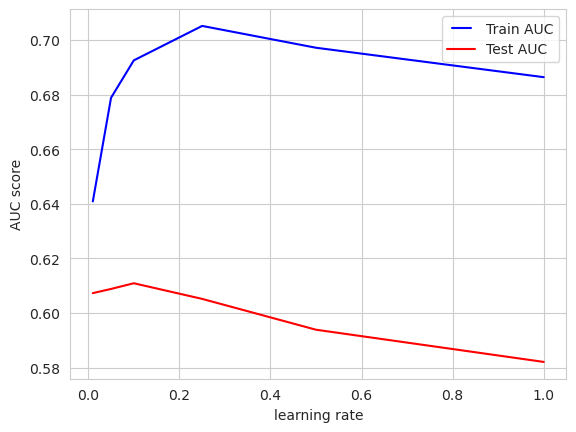

In [74]:
# learning rates 
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
   model = HistGradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

# plot evaluation 
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

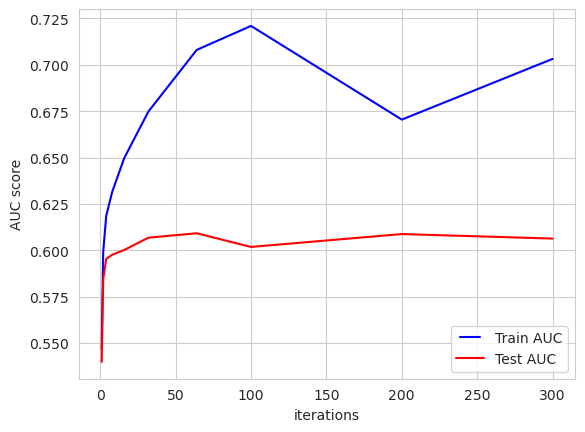

In [89]:
# iterations
max_iter = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300]
train_results = []
test_results = []
for num_iter in max_iter:
   model = HistGradientBoostingClassifier(max_iter=num_iter)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

# plot evaluation 
line1, = plt.plot(max_iter, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_iter, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('iterations')
plt.show()

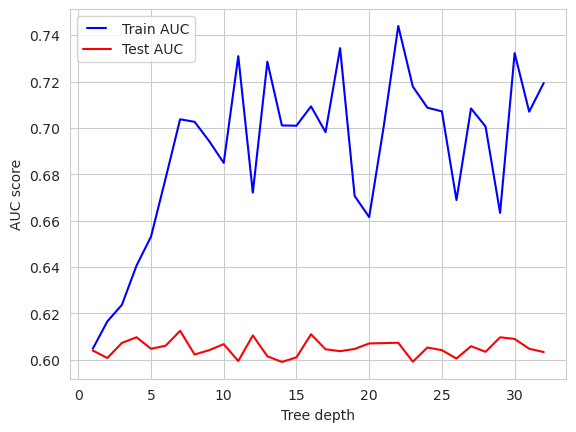

In [83]:
# max depths 
max_depths = np.linspace(1, 32, 32, endpoint=True).astype(int)
train_results = []
test_results = []
for max_depth in max_depths:
   model = HistGradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

# plot evaluation 
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

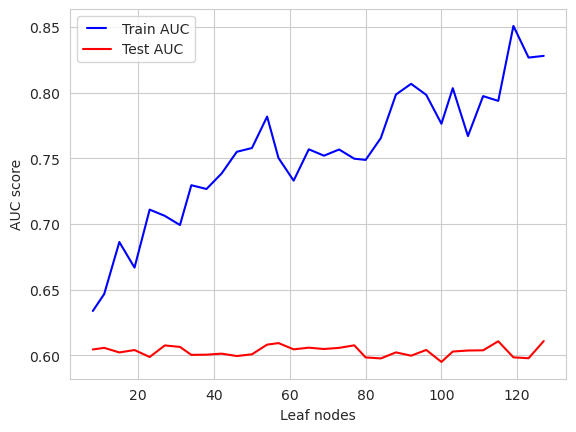

In [88]:
# max leaf nodes (defualt 31) 
max_leafs = np.linspace(8, 127, 32, endpoint=True).astype(int)
train_results = []
test_results = []
for leaf in max_leafs:
   model = HistGradientBoostingClassifier(max_leaf_nodes=leaf)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

# plot evaluation 
line1, = plt.plot(max_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Leaf nodes')
plt.show()

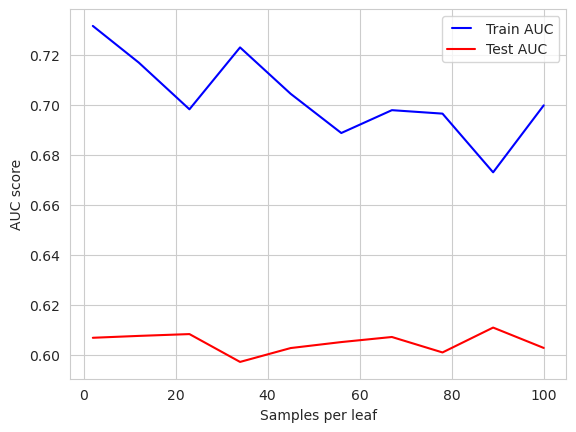

In [108]:
# min_samples_leaf (default 20) 
min_samples = np.linspace(2, 100, 10, endpoint=True).astype(int)
train_results = []
test_results = []
for samp in min_samples:
   model = HistGradientBoostingClassifier(min_samples_leaf=samp)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

# plot evaluation 
line1, = plt.plot(min_samples, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Samples per leaf')
plt.show()

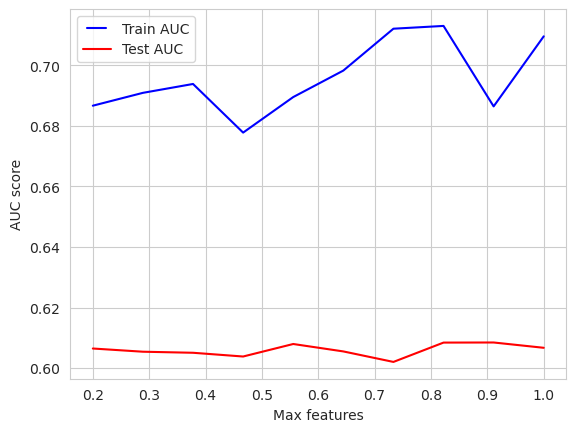

In [102]:
# max_features (defualt 1)
max_feat = np.linspace(0.2, 1, 10, endpoint=True)
train_results = []
test_results = []
for feat in max_feat:
   model = HistGradientBoostingClassifier(max_features=feat)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

# plot evaluation 
line1, = plt.plot(max_feat, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_feat, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Max features')
plt.show()

In [122]:
# Dictionary to store trained models
trained_models = {}

# List to store results
results = []

# Step 5: Train the best model on the full training set
best_params = {'learning_rate': 0.1, 'max_iter': 64, 'max_depth': 6, 
               'max_leaf_nodes': 31, 'min_samples_leaf': 22, 
              'categorical_features':X_train.select_dtypes(include=['boolean']).columns}
best_rf = HistGradientBoostingClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Store the trained model dynamically
model_name = f"histxgb_{bacteria}_{antibiotic}"
trained_models[model_name] = best_rf

# Step 6: Evaluate the model on the test set
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
total_count = len(df_subset)

# Count number of samples in test set
test_count = len(y_test)
actual_susceptible_count = (y_test == 1).sum()

# Count number of predicted 1s (susceptible cases)
predicted_susceptible_count = (y_pred == 1).sum()

# Step 7: Store results with all required metrics
results.append({
        'bacteria': bacteria,
        'antibiotic': antibiotic,
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        # 'total_count': len(df_subset),
        # 'susceptible_count': susceptible_count,
        'test_set_count': test_count,
        'test_set_actual_susceptible_count': actual_susceptible_count,
        'test_set_predicted_susceptible_count': predicted_susceptible_count,
        'n_estimators': best_params.get('n_estimators'),
        'max_depth': best_params.get('max_depth'),
        'min_samples_split': best_params.get('min_samples_split')
    })

# get AUC for evaluation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6126625965954404

In [123]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,bacteria,antibiotic,model_name,accuracy,precision,recall,f1_score,test_set_count,test_set_actual_susceptible_count,test_set_predicted_susceptible_count,n_estimators,max_depth,min_samples_split
0,ESCHERICHIA COLI,AMPICILLIN,histxgb_ESCHERICHIA COLI_AMPICILLIN,0.610,0.582,0.710,0.640,4109,2001,2443,None,6,None


### PCA Exploration

- Doesn't handle missing values 

In [41]:
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

In [43]:
# test with one bacteria / antibiotic combination 
bacteria, antibiotic = pairs[0]

# Step 1: Filter the dataset for the specific bacteria-antibiotic combination
df_subset = modeling_df[(modeling_df['org_name'] == bacteria) & (modeling_df['ab_name'] == antibiotic)]
df_subset = df_subset.dropna()
    
# Step 2: Train-Test Split (80-20)
X = df_subset.drop(columns=['org_name', 'ab_name', 'susceptible_flag'])
y = df_subset['susceptible_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Scale numeric features 
num_cols = X_train.select_dtypes(include=['number']).columns
# fit scaler on training data 
scaler = StandardScaler().fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [50]:
df_subset.shape

(12174, 1043)

Text(0, 0.5, 'Second Principal Component')

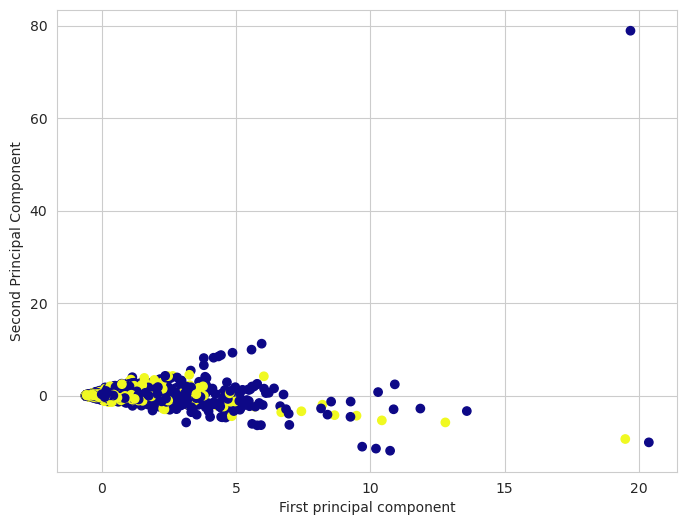

In [53]:
pca = PCA(n_components=2)
scaler = StandardScaler()

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')